In [1]:
from sklearn import model_selection, tree
import graphviz
import pandas as pd
import numpy as np
import re
import pydotplus 
from IPython.display import Image
from sklearn import model_selection, metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('german.data.txt', sep=' ', header=None)
data.head()

0   1    2    3     4    5    6   7    8     9  ...    11  12    13    14  \
0  A11   6  A34  A43  1169  A65  A75   4  A93  A101 ...  A121  67  A143  A152   
1  A12  48  A32  A43  5951  A61  A73   2  A92  A101 ...  A121  22  A143  A152   
2  A14  12  A34  A46  2096  A61  A74   2  A93  A101 ...  A121  49  A143  A152   
3  A11  42  A32  A42  7882  A61  A74   2  A93  A103 ...  A122  45  A143  A153   
4  A11  24  A33  A40  4870  A61  A73   3  A93  A101 ...  A124  53  A143  A153   

  15    16 17    18    19 20  
0  2  A173  1  A192  A201  1  
1  1  A173  1  A191  A201  2  
2  1  A172  2  A191  A201  1  
3  1  A173  2  A191  A201  1  
4  2  A173  2  A191  A201  2  

[5 rows x 21 columns]

Вытащим из описания названия признаков и значения категориальных переменных.

In [3]:
with open('german.doc') as f:
    description = f.readlines()
properties_names = []
properties = {}

description = map(lambda s: s.strip(), description)

for i in xrange(len(description)):
    if re.match('Attr?ibute \d+', description[i]):
        i += 1
        properties_names += [description[i]]
    match = re.match('(A\d+) : (.*)', description[i])
    if match:
        properties[match.group(1)] = match.group(2)
properties_names += ['Give credit']

In [4]:
data.columns = properties_names
data.replace(properties, inplace=True)
print 'число признаков =', len(data.columns) - 1
data.head()

число признаков = 20


Status of existing checking account  Duration in month  \
0                       ... <    0 DM                  6   
1                  0 <= ... <  200 DM                 48   
2                 no checking account                 12   
3                       ... <    0 DM                 42   
4                       ... <    0 DM                 24   

                             Credit history              Purpose  \
0                         critical account/     radio/television   
1  existing credits paid back duly till now     radio/television   
2                         critical account/            education   
3  existing credits paid back duly till now  furniture/equipment   
4           delay in paying off in the past            car (new)   

   Credit amount          Savings account/bonds Present employment since  \
0           1169    unknown/ no savings account            .. >= 7 years   
1           5951                  ... <  100 DM      1  <= ... < 4 years   
2           2096                  ... <  100 DM      4  <= ... < 7 years   
3           7882                  ... <  100 DM      4  <= ... < 7 years   
4           4870                  ... <  100 DM      1  <= ... < 4 years   

   Installment rate in percentage of disposable income  \
0                                                  4     
1                                                  2     
2                                                  2     
3                                                  2     
4                                                  3     

               Personal status and sex Other debtors / guarantors     ...      \
0                      male   : single                       none     ...       
1  female : divorced/separated/married                       none     ...       
2                      male   : single                       none     ...       
3                      male   : single                  guarantor     ...       
4                      male   : single                       none     ...       

                                            Property Age in years  \
0                                        real estate           67   
1                                        real estate           22   
2                                        real estate           49   
3  if not A121 : building society savings agreement/           45   
4                              unknown / no property           53   

   Other installment plans   Housing Number of existing credits at this bank  \
0                     none       own                                       2   
1                     none       own                                       1   
2                     none       own                                       1   
3                     none  for free                                       1   
4                     none  for free                                       2   

                           Job  \
0  skilled employee / official   
1  skilled employee / official   
2         unskilled - resident   
3  skilled employee / official   
4  skilled employee / official   

  Number of people being liable to provide maintenance for  \
0                                                  1         
1                                                  1         
2                                                  2         
3                                                  2         
4                                                  2         

                                  Telephone foreign worker Give credit  
0  yes, registered under the customers name            yes           1  
1                                      none            yes           2  
2                                      none            yes           1  
3                                      none            yes           1  
4                                      none            yes           2  

[5 rows x 21 columns]

Теперь закодируем категориальные признаки, чтобы передать датасет дереву.

In [5]:
data_encode = pd.get_dummies(data)
print 'Теперь число признаков =', len(data_encode.columns) - 1
data_encode.head()

Теперь число признаков = 61


Duration in month  Credit amount  \
0                  6           1169   
1                 48           5951   
2                 12           2096   
3                 42           7882   
4                 24           4870   

   Installment rate in percentage of disposable income  \
0                                                  4     
1                                                  2     
2                                                  2     
3                                                  2     
4                                                  3     

   Present residence since  Age in years  \
0                        4            67   
1                        2            22   
2                        3            49   
3                        4            45   
4                        4            53   

   Number of existing credits at this bank  \
0                                        2   
1                                        1   
2                                        1   
3                                        1   
4                                        2   

   Number of people being liable to provide maintenance for  Give credit  \
0                                                  1                   1   
1                                                  1                   2   
2                                                  2                   1   
3                                                  2                   1   
4                                                  2                   2   

   Status of existing checking account_     ... <    0 DM  \
0                                                  1        
1                                                  0        
2                                                  0        
3                                                  1        
4                                                  1        

   Status of existing checking account_     ... >= 200 DM /  \
0                                                  0          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

          ...          Housing_own  Housing_rent  \
0         ...                    1             0   
1         ...                    1             0   
2         ...                    1             0   
3         ...                    0             0   
4         ...                    0             0   

   Job_management/ self-employed/  Job_skilled employee / official  \
0                               0                                1   
1                               0                                1   
2                               0                                0   
3                               0                                1   
4                               0                                1   

   Job_unemployed/ unskilled  - non-resident  Job_unskilled - resident  \
0                                          0                         0   
1                                          0                         0   
2                                          0                         1   
3                                          0                         0   
4                                          0                         0   

   Telephone_none  Telephone_yes, registered under the customers name  \
0               0                                                  1    
1               1                                                  0    
2               1                                                  0    
3               1                                                  0    
4               1                                                  0    

   foreign worker_no  foreign worker_yes  
0            

Так же сделаем приведем target к классам 0 - не давать кредит, 1 - давать.

In [6]:
data_encode[u'Give credit'] = data_encode[u'Give credit'].apply(lambda x: 0 if x == 2 else 1)
y = data_encode[u'Give credit']
X = data_encode.drop((u'Give credit'), axis=1)

In [7]:
print 'Доли классов'
print '{} объектов 1-го класса'.format((y==1).sum() * 1./len(y))
print '{} объектов 0-го класса'.format((y==0).sum() * 1./len(y))

Доли классов
0.7 объектов 1-го класса
0.3 объектов 0-го класса


Построим дерево, получающееся при ограничении глубины не больше 3

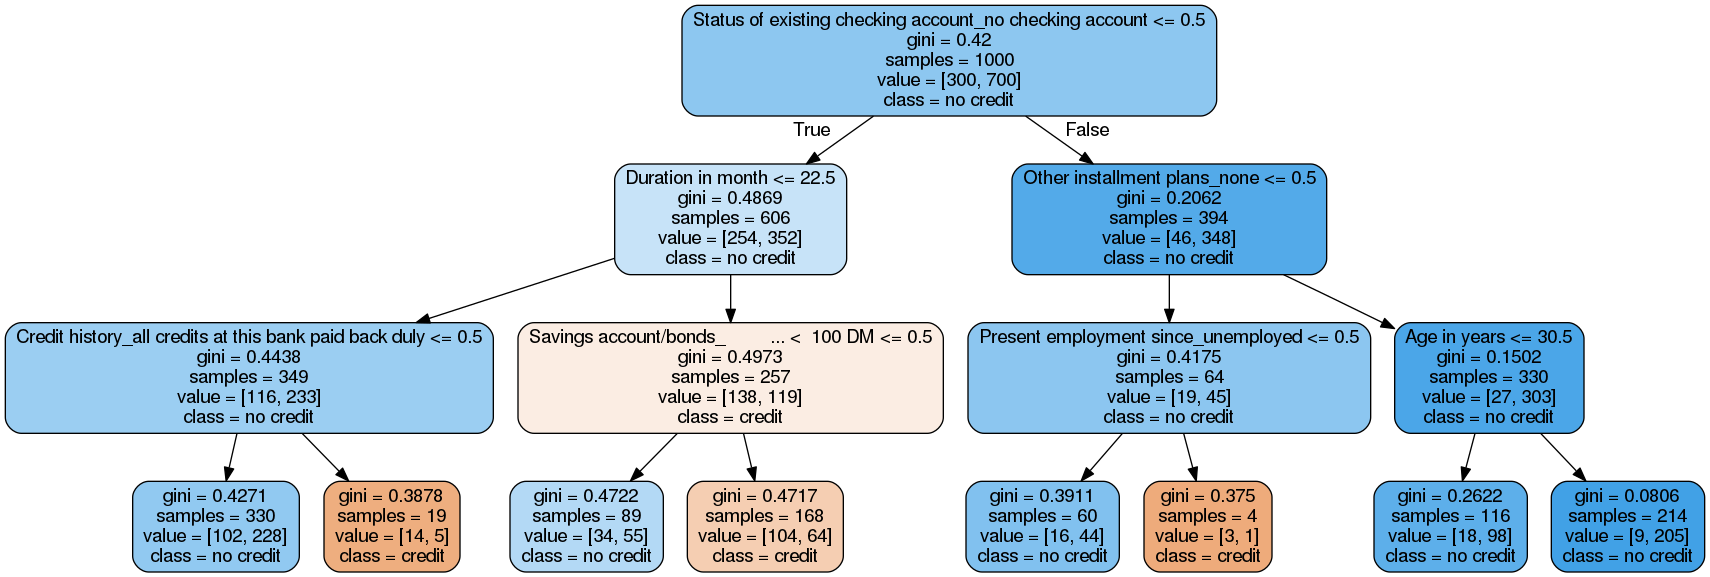

In [8]:
classifier = tree.DecisionTreeClassifier(max_depth=3)
classifier.fit(X, y)
dot_data = tree.export_graphviz(classifier, out_file="tree3.out", 
                         feature_names=X.columns,  
                         class_names=['credit', 'no credit'],  
                         filled=True, rounded=True,  
                         special_characters=False)  
graph = pydotplus.graphviz.graph_from_dot_file("tree3.out")  
Image(graph.create_png())  

Глубина не больше 6

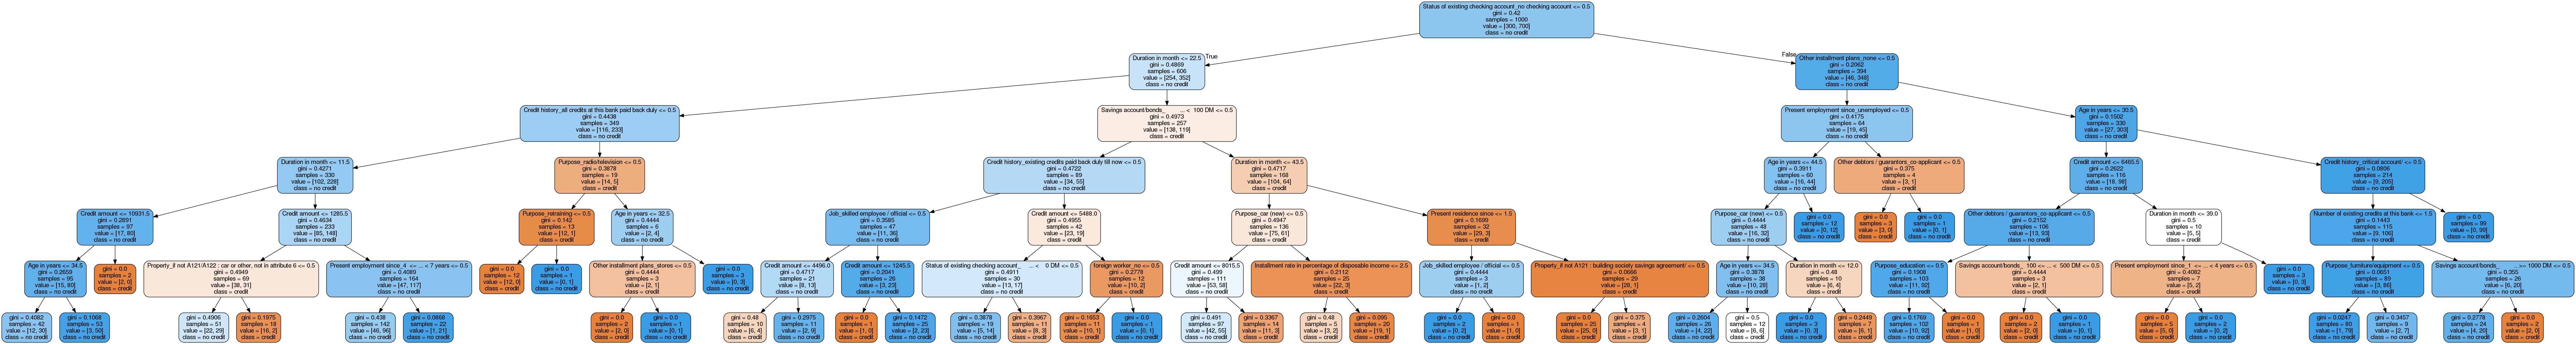

In [9]:
classifier = tree.DecisionTreeClassifier(max_depth=6)
classifier.fit(X, y)
dot_data = tree.export_graphviz(classifier, out_file="tree6.out", 
                         feature_names=X.columns,  
                         class_names=['credit', 'no credit'],  
                         filled=True, rounded=True,  
                         special_characters=False)  
graph = pydotplus.graphviz.graph_from_dot_file("tree6.out")  
Image(graph.create_png())  

Без ограничения

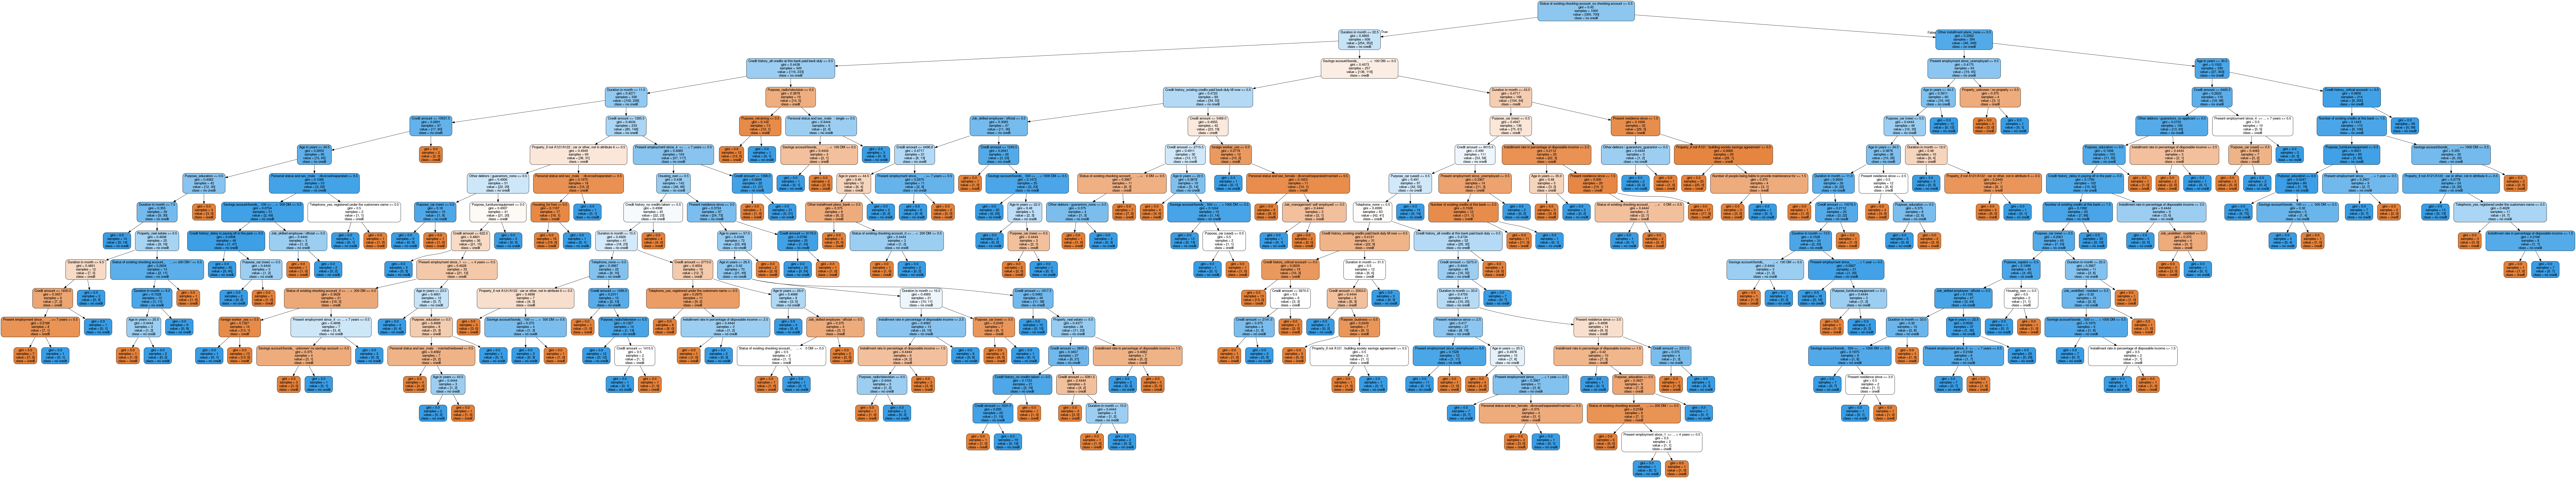

In [10]:
classifier = tree.DecisionTreeClassifier()
classifier.fit(X, y)
dot_data = tree.export_graphviz(classifier, out_file="tree.out", 
                         feature_names=X.columns,  
                         class_names=['credit', 'no credit'],  
                         filled=True, rounded=True,  
                         special_characters=False)  
graph = pydotplus.graphviz.graph_from_dot_file("tree.out")  
Image(graph.create_png())  

Теперь посмотрим на зависимость качества от глубины.

In [11]:
depths = np.arange(1, 30)
scores = []
train_score = []
X_train, y_train, X_test, y_test = model_selection.train_test_split(X, y, test_size=0.3)
for depth in depths:
    model = tree.DecisionTreeClassifier(max_depth=depth)
    scores += [model_selection.cross_val_score(model, X, y, scoring='roc_auc').mean()]
    model.fit(X, y)
    train_score += [metrics.roc_auc_score(y, model.predict(X))]

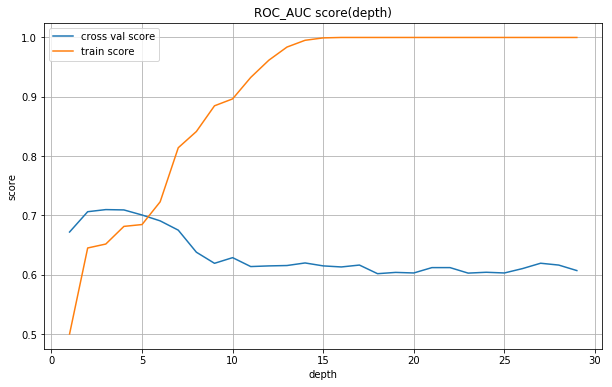

In [12]:
plt.figure(figsize=(10, 6))
plt.title('ROC_AUC score(depth)')
plt.plot(depths, scores, label='cross val score')
plt.plot(depths, train_score, label='train score')
plt.grid(True)
plt.xlabel('depth')
plt.ylabel('score')
plt.legend(loc='best')
plt.show()

In [13]:
print 'best depth =', np.argmax(scores) + 1

best depth = 3
